In [4]:
import os
import warnings
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.linalg import LinAlgError
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression, LassoLars
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Model Deployment and Reproduction

In [6]:
# Load data frames
df_full = pd.read_csv("df_full.csv")
train_df = pd.read_csv("train_df.csv")
val_df = pd.read_csv("val_df.csv")
test_df = pd.read_csv("test_df.csv")

In [8]:
# Define custom classes for unpickling
class DiffModel:
    def __init__(self, in_model, out_model):
        self.in_model = in_model
        self.out_model = out_model
    def predict(self, X): 
        return self.in_model.predict(X) - self.out_model.predict(X)

class EnsembleModel:
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights
    def predict(self, X): 
        return sum(self.weights[n] * m.predict(X) for n, m in self.models.items())

class RawEnsemble:
    def __init__(self, pipelines, weights=None):
        self.pipelines = pipelines
        self.pipes = pipelines
        self.weights = weights or [1/len(pipelines)] * len(pipelines)
    def predict(self, X):
        pipes = getattr(self, "pipelines", None) or getattr(self, "pipes", [])
        preds = np.vstack([p.predict(X) for p in self.pipes]).T
        return preds.dot(self.weights)

# Load everything
feature_groups = joblib.load("feature_groups.pkl")

N_bal_model = joblib.load("N_bal_diff_model.pkl")
P_bal_model = joblib.load("P_bal_diff_model.pkl")
K_bal_model = joblib.load("K_bal_direct_model.pkl")  
S_bal_model = joblib.load("S_bal_direct_model.pkl")

# Evaluation

## Performance 

In [11]:
models = {
    "N": N_bal_model,  # predicts N_bal
    "P": P_bal_model,  # predicts P_bal
    "K": K_bal_model,  # predicts K_bal
    "S": S_bal_model   # predicts S_bal
}

datasets = {
    "train": train_df,
    "val":   val_df,
    "test":  test_df
}

# Compute performance
rows = []
for ds_name, df in datasets.items():
    for prefix, model in models.items():
        # true balance = in - out
        y_true = (df[f"{prefix}_in"] - df[f"{prefix}_out"]).values
        # predicted balance
        y_pred = model.predict(df)
        # metrics
        r2   = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        rows.append({
            "dataset": ds_name,
            "target": f"{prefix}_bal",
            "R2":       r2,
            "RMSE":     rmse
        })

summary = pd.DataFrame(rows)
print("Balance models performance:")
print(summary.pivot(index="target", columns="dataset", values=["R2","RMSE"]))

Balance models performance:
               R2                          RMSE                     
dataset      test     train       val      test     train        val
target                                                              
K_bal    0.908090  0.919099  0.859033  5.738286  6.375420   7.459905
N_bal    0.926906  0.932253  0.825084  8.286618  8.035092  10.222852
P_bal    0.984313  0.992585  0.981758  2.005817  1.480789   1.924813
S_bal    0.887014  0.937201  0.881037  1.295187  1.006366   1.505219


In [19]:
# 1. Define function to calculate MAPE
def safe_mape(y_true, y_pred):
    """Safely calculate MAPE, handling zero values"""
    mask = y_true != 0  # Only consider points where true values are not zero
    if np.sum(mask) == 0:  # All true values are zero
        return np.nan
    abs_perc_errors = np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])
    return np.mean(abs_perc_errors) * 100  # Convert to percentage

# 2. Organise models and datasets
models = {
    "N": N_bal_model,  # predicts N_bal
    "P": P_bal_model,  # predicts P_bal
    "K": K_bal_model,  # predicts K_bal
    "S": S_bal_model   # predicts S_bal
}

datasets = {
    "train": train_df,
    "val": val_df,
    "test": test_df
}

# 3. Calculate performance metrics
rows = []
for ds_name, df in datasets.items():
    for prefix, model in models.items():
        # True balance = input - output
        y_true = (df[f"{prefix}_in"] - df[f"{prefix}_out"]).values
        
        # Predicted balance
        y_pred = model.predict(df)
        
        # Calculate various metrics
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = safe_mape(y_true, y_pred)
        
        rows.append({
            "dataset": ds_name,
            "target": f"{prefix}_bal",
            "R2": r2,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE (%)": mape
        })

# 4. Create summary table and format
summary = pd.DataFrame(rows)

# Sort datasets in required order: train, val, test
dataset_order = ["train", "val", "test"]
summary["dataset"] = pd.Categorical(summary["dataset"], categories=dataset_order, ordered=True)

# Create pivot table
pivot_df = summary.pivot(index="target", columns="dataset", 
                         values=["R2", "MAE", "RMSE", "MAPE (%)"])

# Reorder column levels to ensure correct dataset order
pivot_df = pivot_df.reindex(columns=dataset_order, level=1)

# 5. Format values to 4 decimal places
for col in pivot_df.columns.levels[0]:
    pivot_df[col] = pivot_df[col].applymap(lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x)

# 6. Print results
print("Balance models performance:")
print(pivot_df)


Balance models performance:
             R2                     MAE                    RMSE           \
dataset   train     val    test   train     val    test   train      val   
target                                                                     
K_bal    0.9191  0.8590  0.9081  4.5817  5.7231  4.3471  6.3754   7.4599   
N_bal    0.9323  0.8251  0.9269  5.9258  7.7158  6.7296  8.0351  10.2229   
P_bal    0.9926  0.9818  0.9843  1.1311  1.3290  1.4618  1.4808   1.9248   
S_bal    0.9372  0.8810  0.8870  0.7732  1.1780  1.0106  1.0064   1.5052   

                 MAPE (%)                     
dataset    test     train      val      test  
target                                        
K_bal    5.7383   59.4045  56.4910   76.0801  
N_bal    8.2866  291.2693  60.0744  117.2208  
P_bal    2.0058   16.3851  18.7361   17.1083  
S_bal    1.2952   63.6569  93.1793  157.2731  


/var/folders/qx/5zbpywt5661d6xr06v91bdyr0000gn/T/ipykernel_36293/1920844911.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_df[col] = pivot_df[col].applymap(lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x)


In [21]:
# Set plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'  # Use a more friendly font
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10

# 1. Create performance visualization function
def visualize_performance(summary_df):
    """
    Visualize model performance metrics
    
    Parameters:
    summary_df - DataFrame containing performance metrics
    """
    # Copy the DataFrame to avoid modifying the original
    df = summary_df.copy()
    
    # Prepare data for plotting
    df['model'] = df['target']  # Directly use the target column
    df['dataset'] = pd.Categorical(df['dataset'], categories=['train', 'val', 'test'], ordered=True)
    
    # Create layout - 4 rows, 1 column
    fig, axes = plt.subplots(4, 1, figsize=(10, 16))
    fig.suptitle('Model Performance Metrics', fontsize=18, y=0.98)
    
    # Colour palette
    palette = {'train': '#1f77b4', 'val': '#ff7f0e', 'test': '#2ca02c'}
    
    # 1. R² metric
    ax = axes[0]
    sns.barplot(data=df, x='model', y='R2', hue='dataset', palette=palette, ax=ax)
    ax.set_title('R² Score Comparison')
    ax.set_ylabel('R²')
    ax.set_xlabel('Target')
    ax.set_ylim(0, 1.05)
    
    # Add value labels to bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9)
    
    # Move legend to the right
    ax.legend(title='Dataset', loc='center left', bbox_to_anchor=(1, 0.5))
    
    # 2. RMSE metric
    ax = axes[1]
    sns.barplot(data=df, x='model', y='RMSE', hue='dataset', palette=palette, ax=ax)
    ax.set_title('RMSE Comparison')
    ax.set_ylabel('RMSE')
    ax.set_xlabel('Target')
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9)
    
    ax.legend(title='Dataset', loc='center left', bbox_to_anchor=(1, 0.5))
    
    # 3. MAE metric
    ax = axes[2]
    sns.barplot(data=df, x='model', y='MAE', hue='dataset', palette=palette, ax=ax)
    ax.set_title('MAE Comparison')
    ax.set_ylabel('MAE')
    ax.set_xlabel('Target')
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9)
    
    ax.legend(title='Dataset', loc='center left', bbox_to_anchor=(1, 0.5))
    
    # 4. MAPE metric
    ax = axes[3]
    # Handle NaN values (MAPE may be NaN)
    mape_df = df.dropna(subset=['MAPE (%)'])
    if not mape_df.empty:
        sns.barplot(data=mape_df, x='model', y='MAPE (%)', hue='dataset', palette=palette, ax=ax)
        ax.set_title('MAPE Comparison')
        ax.set_ylabel('MAPE (%)')
        ax.set_xlabel('Target')
        
        for container in ax.containers:
            ax.bar_label(container, fmt='%.1f%%', padding=3, fontsize=9)
        
        ax.legend(title='Dataset', loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.text(0.5, 0.5, 'No MAPE data available', 
                ha='center', va='center', fontsize=12)
        ax.set_title('MAPE Comparison - No Data')
        ax.set_xlabel('Target')
    
    # Adjust layout (leave space for legends on the right)
    plt.tight_layout(rect=[0, 0, 0.85, 0.98])
    return fig

# 2. Create performance trend plots
def plot_metric_trends(summary_df):
    """
    Show performance trends of each model across three datasets
    
    Parameters:
    summary_df - DataFrame containing performance metrics
    """
    df = summary_df.copy()
    df['model'] = df['target']
    df['dataset'] = pd.Categorical(df['dataset'], categories=['train', 'val', 'test'], ordered=True)
    
    # Create figure - 4 rows, 1 column
    fig, axes = plt.subplots(4, 1, figsize=(10, 16))
    fig.suptitle('Model Performance Trends Across Datasets', fontsize=18, y=0.98)
    
    # Group by model
    models = df['target'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
    
    # 1. R² trend
    ax = axes[0]
    for i, model in enumerate(models):
        model_df = df[df['target'] == model]
        line, = ax.plot(model_df['dataset'], model_df['R2'], 
                marker='o', label=model, color=colors[i], linewidth=2.5)
        
        for j, (x, y) in enumerate(zip(model_df['dataset'], model_df['R2'])):
            ax.annotate(f'{y:.3f}', (x, y), 
                        textcoords="offset points", 
                        xytext=(0, 10 if j % 2 == 0 else -15),
                        ha='center', fontsize=9)
    
    ax.set_title('R² Trend')
    ax.set_ylabel('R²')
    ax.set_xlabel('Target')
    ax.set_ylim(0.5, 1.05)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # 2. RMSE trend
    ax = axes[1]
    for i, model in enumerate(models):
        model_df = df[df['target'] == model]
        line, = ax.plot(model_df['dataset'], model_df['RMSE'], 
                marker='o', label=model, color=colors[i], linewidth=2.5)
        
        for j, (x, y) in enumerate(zip(model_df['dataset'], model_df['RMSE'])):
            ax.annotate(f'{y:.3f}', (x, y), 
                        textcoords="offset points", 
                        xytext=(0, 10 if j % 2 == 0 else -15),
                        ha='center', fontsize=9)
    
    ax.set_title('RMSE Trend')
    ax.set_ylabel('RMSE')
    ax.set_xlabel('Target')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # 3. MAE trend
    ax = axes[2]
    for i, model in enumerate(models):
        model_df = df[df['target'] == model]
        line, = ax.plot(model_df['dataset'], model_df['MAE'], 
                marker='o', label=model, color=colors[i], linewidth=2.5)
        
        for j, (x, y) in enumerate(zip(model_df['dataset'], model_df['MAE'])):
            ax.annotate(f'{y:.3f}', (x, y), 
                        textcoords="offset points", 
                        xytext=(0, 10 if j % 2 == 0 else -15),
                        ha='center', fontsize=9)
    
    ax.set_title('MAE Trend')
    ax.set_ylabel('MAE')
    ax.set_xlabel('Target')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # 4. MAPE trend (if available)
    ax = axes[3]
    has_mape_data = False
    for i, model in enumerate(models):
        model_df = df[df['target'] == model].dropna(subset=['MAPE (%)'])
        if not model_df.empty:
            line, = ax.plot(model_df['dataset'], model_df['MAPE (%)'], 
                    marker='o', label=model, color=colors[i], linewidth=2.5)
            has_mape_data = True
            
            for j, (x, y) in enumerate(zip(model_df['dataset'], model_df['MAPE (%)'])):
                ax.annotate(f'{y:.1f}%', (x, y), 
                            textcoords="offset points", 
                            xytext=(0, 10 if j % 2 == 0 else -15),
                            ha='center', fontsize=9)
    
    if has_mape_data:
        ax.set_title('MAPE Trend')
        ax.set_ylabel('MAPE (%)')
        ax.set_xlabel('Target')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.text(0.5, 0.5, 'No MAPE data available', 
                ha='center', va='center', fontsize=12)
        ax.set_title('MAPE Trend - No Data')
        ax.set_xlabel('Target')
    
    plt.tight_layout(rect=[0, 0, 0.85, 0.98])
    return fig

# 3. Save visualisation results
def save_visualizations(summary_df, prefix="model_performance"):
    """
    Generate and save all visualisation results
    
    Parameters:
    summary_df - DataFrame containing performance metrics
    prefix - file name prefix
    """
    # Create visualisations
    fig1 = visualize_performance(summary_df)
    fig2 = plot_metric_trends(summary_df)
    
    # Save results
    fig1.savefig(f"{prefix}_comparison.png", dpi=300, bbox_inches='tight')
    fig2.savefig(f"{prefix}_trends.png", dpi=300, bbox_inches='tight')
    
    # Close figures to free memory
    plt.close(fig1)
    plt.close(fig2)
    
    print(f"Visualizations saved as {prefix}_comparison.png and {prefix}_trends.png")

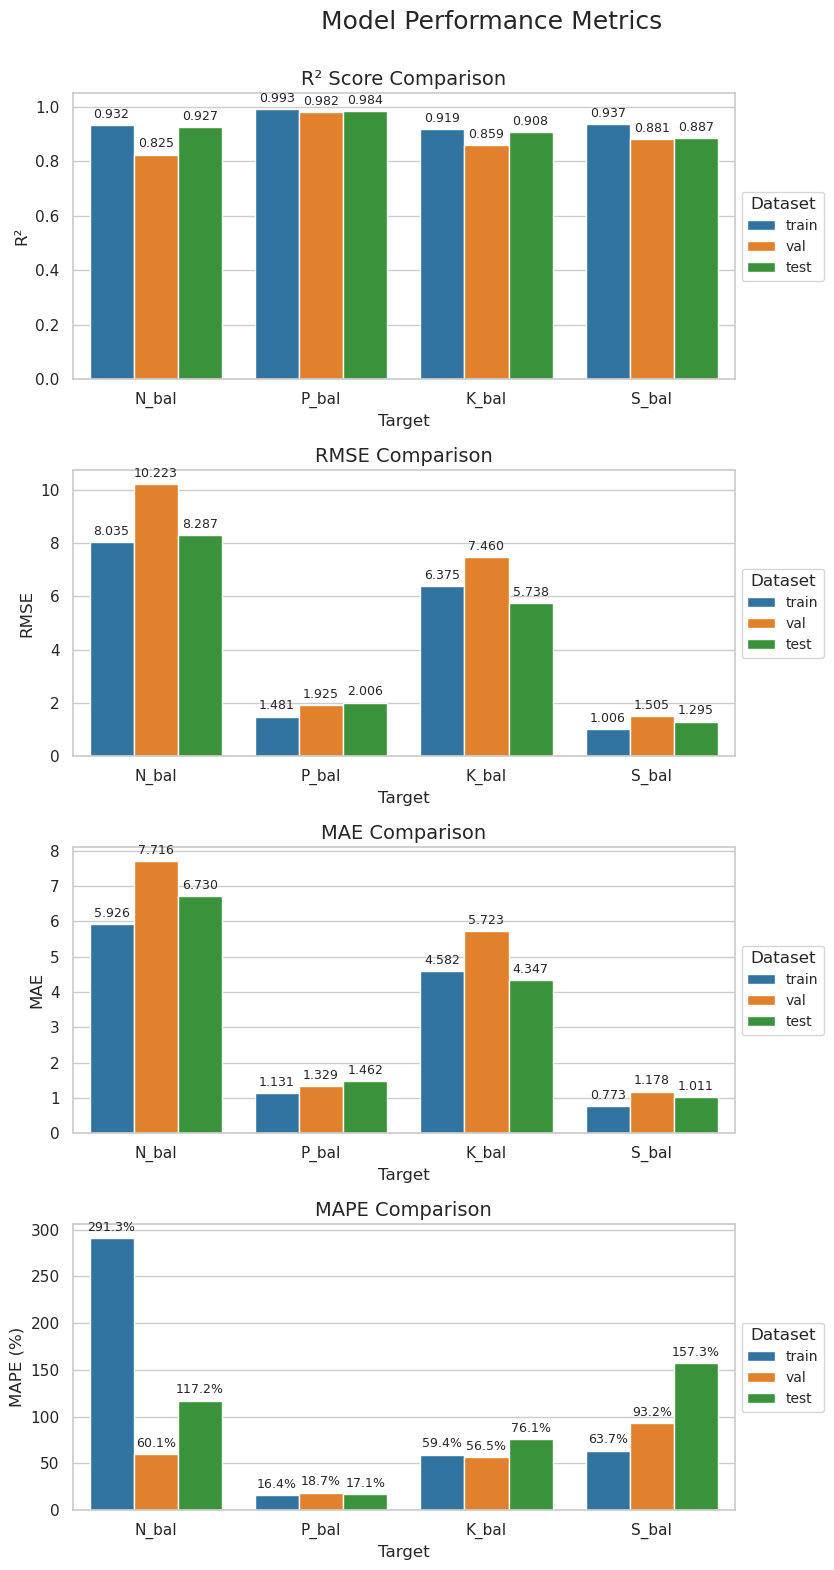

In [23]:
fig = visualize_performance(summary)
plt.show()

In [25]:
save_visualizations(summary)

Visualizations saved as model_performance_comparison.png and model_performance_trends.png


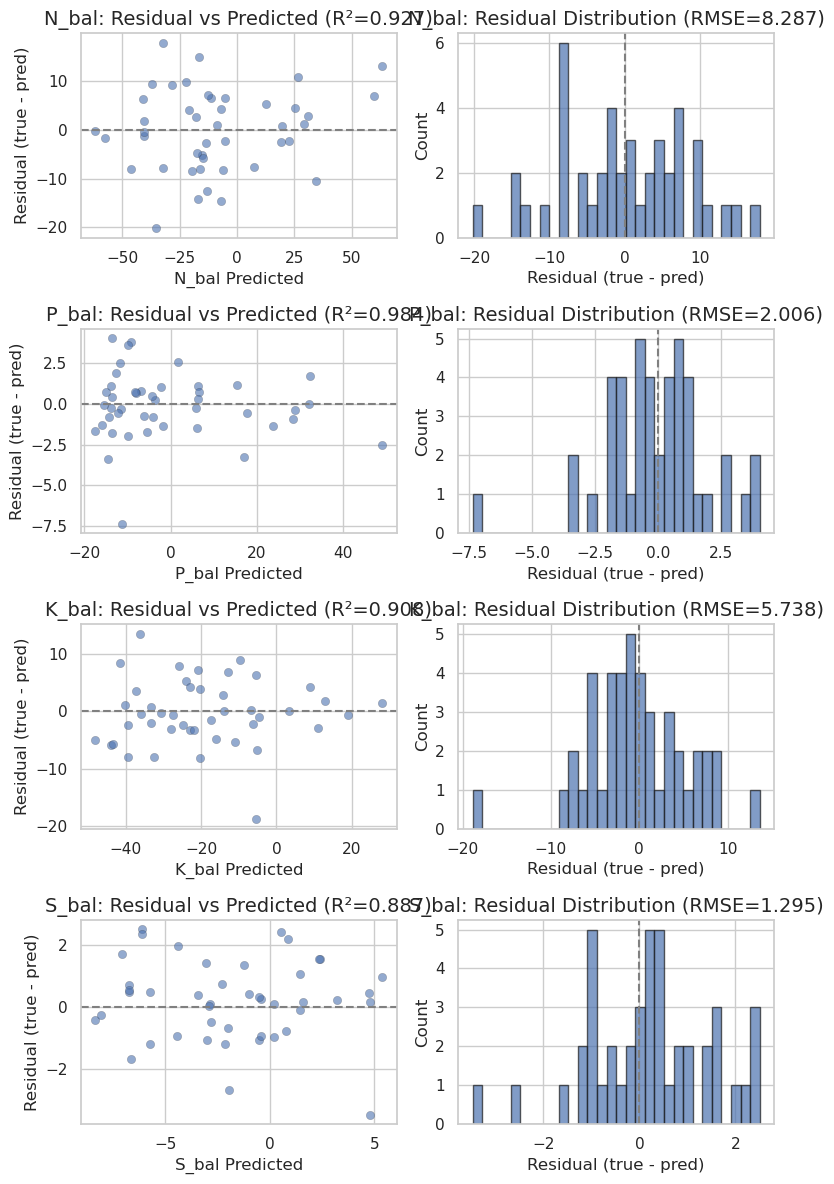

In [27]:
# Residual Analysis
models = {
    "N_bal": N_bal_model,
    "P_bal": P_bal_model,
    "K_bal": K_bal_model,
    "S_bal": S_bal_model
}

# Compute true balances on test_df
true_balances = {
    "N_bal": test_df["N_in"] - test_df["N_out"],
    "P_bal": test_df["P_in"] - test_df["P_out"],
    "K_bal": test_df["K_in"] - test_df["K_out"],
    "S_bal": test_df["S_in"] - test_df["S_out"]
}

# Prepare figure: 4 rows x 2 columns (scatter, histogram)
fig, axes = plt.subplots(len(models), 2, figsize=(8, 3 * len(models)))

for i, (name, model) in enumerate(models.items()):
    y_true = true_balances[name].values
    y_pred = model.predict(test_df)
    residuals = y_true - y_pred

    # Scatter: predicted vs residual
    ax_scatter = axes[i, 0]
    ax_scatter.scatter(y_pred, residuals, alpha=0.6, edgecolor='k', linewidth=0.2)
    ax_scatter.axhline(0, color='gray', linestyle='--')
    ax_scatter.set_xlabel(f"{name} Predicted")
    ax_scatter.set_ylabel("Residual (true - pred)")
    ax_scatter.set_title(f"{name}: Residual vs Predicted (R²={r2_score(y_true, y_pred):.3f})")

    # Histogram: residual distribution
    ax_hist = axes[i, 1]
    ax_hist.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
    ax_hist.axvline(0, color='gray', linestyle='--')
    ax_hist.set_xlabel("Residual (true - pred)")
    ax_hist.set_ylabel("Count")
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    ax_hist.set_title(f"{name}: Residual Distribution (RMSE={rmse:.3f})")

plt.tight_layout()
plt.savefig('residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


=== Feature importances for N_bal ===


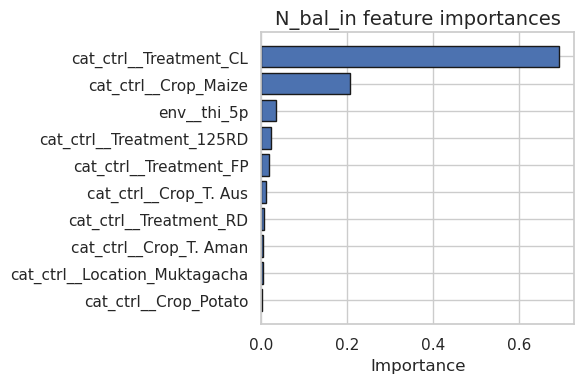

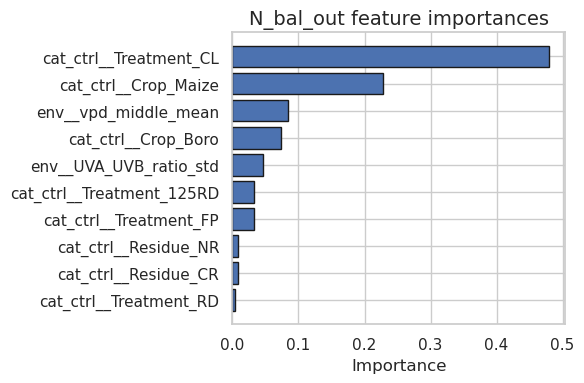


=== Feature importances for P_bal ===


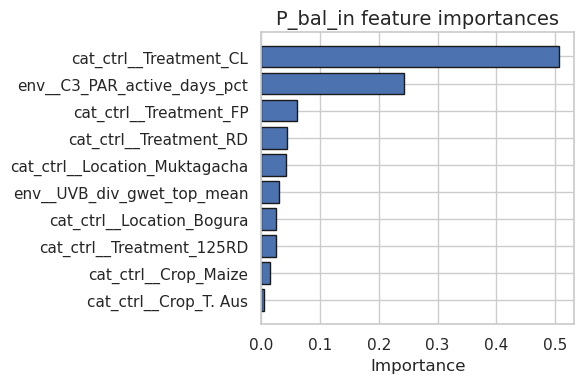

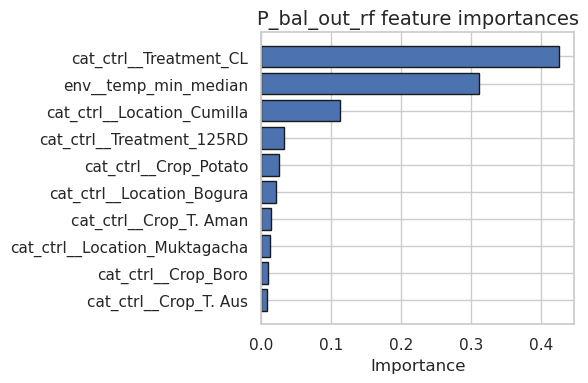

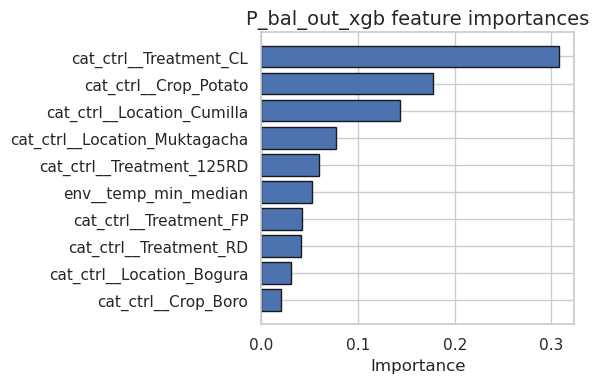


=== Feature importances for K_bal ===


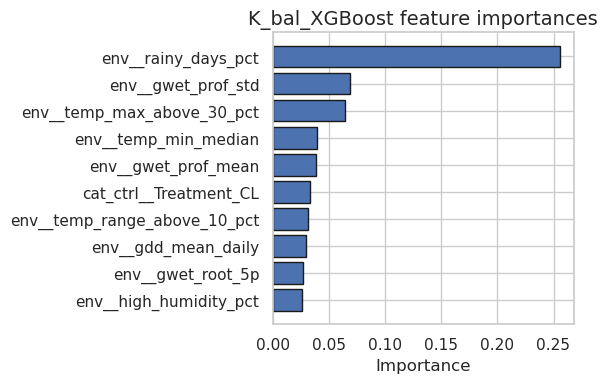

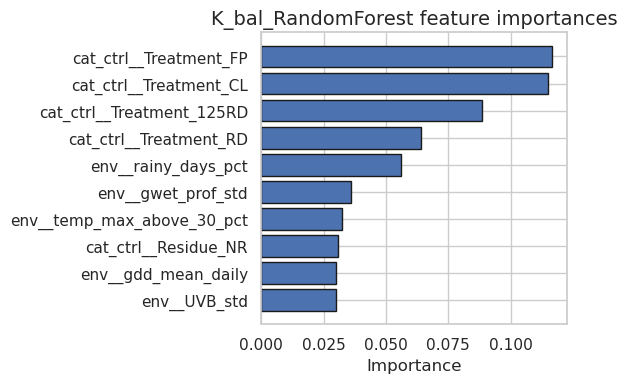


=== Feature importances for S_bal ===


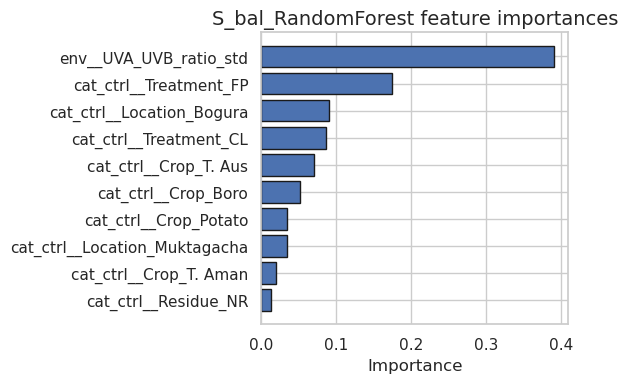

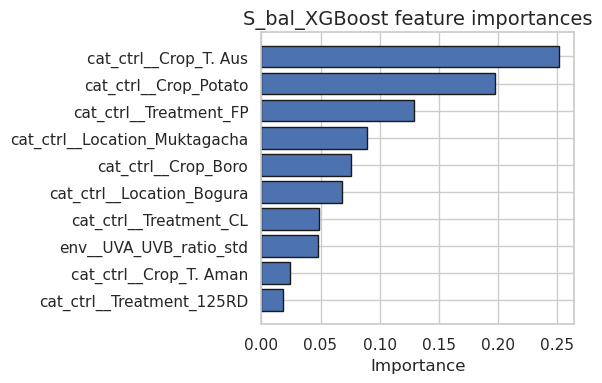

In [29]:
# reload your four balance models
N_bal_model = joblib.load("N_bal_diff_model.pkl")
P_bal_model = joblib.load("P_bal_diff_model.pkl")
K_bal_model = joblib.load("K_bal_direct_model.pkl")
S_bal_model = joblib.load("S_bal_direct_model.pkl")

models = {
    "N_bal": N_bal_model,
    "P_bal": P_bal_model,
    "K_bal": K_bal_model,
    "S_bal": S_bal_model
}

def extract_pipelines(name, model):
    """
    Recursively flatten any DiffModel or RawEnsemble down to sklearn.Pipelines,
    and label each pipeline by its final estimator step name (e.g. 'rf' or 'xgb').
    Returns a list of (label, Pipeline) tuples.
    """
    # DiffModel wrapper
    if hasattr(model, "in_model") and hasattr(model, "out_model"):
        return (
            extract_pipelines(f"{name}_in",  model.in_model) +
            extract_pipelines(f"{name}_out", model.out_model)
        )

    # RawEnsemble: unweighted or weighted list of pipes
    if hasattr(model, "pipes"):
        pipelines = []
        for pipe in model.pipes:
            # figure out the final step name
            if isinstance(pipe, Pipeline):
                final_step = pipe.steps[-1][0]
                label = f"{name}_{final_step}"
            else:
                label = name
            pipelines += extract_pipelines(label, pipe)
        return pipelines

    # Your other ensemble wrapper (if it has .models dict)
    if hasattr(model, "models"):
        pipelines = []
        for key, pipe in model.models.items():
            # assume key is something like 'XGBoost' or 'RandomForest'
            pipelines += extract_pipelines(f"{name}_{key}", pipe)
        return pipelines

    # Base case: a plain sklearn Pipeline
    if isinstance(model, Pipeline):
        return [(name, model)]

    # else: nothing to flatten
    return []

def plot_pipeline_importance(pipe, title, top_n=10):
    feat_names = pipe.named_steps["prep"].get_feature_names_out()
    importances = None

    # find the first downstream step with tree feature_importances_
    for step in reversed(pipe.named_steps.values()):
        if hasattr(step, "feature_importances_"):
            importances = step.feature_importances_
            break
    if importances is None:
        return

    idxs = np.argsort(importances)[::-1][:top_n]
    plt.figure(figsize=(6, top_n * 0.4))
    plt.barh(feat_names[idxs][::-1], importances[idxs][::-1], edgecolor="k")
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()


# now generate properly‐labeled plots for all four balances
for name, model in models.items():
    print(f"\n=== Feature importances for {name} ===")
    for label, pipe in extract_pipelines(name, model):
        plot_pipeline_importance(pipe, title=f"{label} feature importances")


In [31]:
# Reload the four balance models
N_bal_model = joblib.load("N_bal_diff_model.pkl")
P_bal_model = joblib.load("P_bal_diff_model.pkl")
K_bal_model = joblib.load("K_bal_direct_model.pkl")
S_bal_model = joblib.load("S_bal_direct_model.pkl")

models = {
    "N_bal": N_bal_model,
    "P_bal": P_bal_model,
    "K_bal": K_bal_model,
    "S_bal": S_bal_model
}

def extract_pipelines(name, model):
    """
    Recursively flatten any DiffModel or RawEnsemble down to sklearn.Pipelines,
    and label each pipeline by its final estimator step name (e.g. 'rf' or 'xgb').
    Returns a list of (label, Pipeline) tuples.
    """
    # DiffModel wrapper
    if hasattr(model, "in_model") and hasattr(model, "out_model"):
        return (
            extract_pipelines(f"{name}_in", model.in_model) +
            extract_pipelines(f"{name}_out", model.out_model)
        )

    # RawEnsemble: unweighted or weighted list of pipes
    if hasattr(model, "pipes"):
        pipelines = []
        for pipe in model.pipes:
            # Figure out the final step name
            if isinstance(pipe, Pipeline):
                final_step = pipe.steps[-1][0]
                label = f"{name}_{final_step}"
            else:
                label = name
            pipelines += extract_pipelines(label, pipe)
        return pipelines

    # Your other ensemble wrapper (if it has .models dict)
    if hasattr(model, "models"):
        pipelines = []
        for key, pipe in model.models.items():
            # Assume key is something like 'XGBoost' or 'RandomForest'
            pipelines += extract_pipelines(f"{name}_{key}", pipe)
        return pipelines

    # Base case: a plain sklearn Pipeline
    if isinstance(model, Pipeline):
        return [(name, model)]

    # Else: nothing to flatten
    return []

def plot_pipeline_importance(pipe, title, top_n=10, save_dir="feature_importances"):
    """
    Plot pipeline feature importance and save the figure
    
    Parameters:
    pipe - Pipeline object to analyze
    title - Figure title
    top_n - Show top N most important features
    save_dir - Directory to save images
    """
    # Check if it's a valid Pipeline
    if not hasattr(pipe, "named_steps") or "prep" not in pipe.named_steps:
        print(f"Skipping {title}: not a valid Pipeline or missing 'prep' step")
        return
    
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Get feature names
    feat_names = pipe.named_steps["prep"].get_feature_names_out()
    importances = None

    # Find the first downstream step with feature_importances_
    for step in reversed(pipe.named_steps.values()):
        if hasattr(step, "feature_importances_"):
            importances = step.feature_importances_
            break
            
    if importances is None:
        print(f"{title}: no feature importances found")
        return

    # Sort and select top features
    idxs = np.argsort(importances)[::-1][:top_n]
    
    # Create figure
    plt.figure(figsize=(8, top_n * 0.5))
    plt.barh(feat_names[idxs][::-1], importances[idxs][::-1], edgecolor="k")
    plt.title(title)
    plt.xlabel("Feature Importance")
    
    # Add value labels
    for i, v in enumerate(importances[idxs][::-1]):
        plt.text(v + 0.001, i, f"{v:.4f}", va='center', fontsize=9)
    
    plt.tight_layout()
    
    # Create safe filename
    safe_title = "".join(c if c.isalnum() or c in "_- " else "_" for c in title)
    filename = f"{safe_title}.png"
    save_path = os.path.join(save_dir, filename)
    
    # Save figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved feature importance plot: {save_path}")
    
    # Close figure to free memory
    plt.close()

# Create directory to save all feature importance plots
save_directory = "model_feature_importances"

# Generate properly labeled plots for all four balances
for name, model in models.items():
    print(f"\n=== Feature importances for {name} ===")
    for label, pipe in extract_pipelines(name, model):
        plot_pipeline_importance(
            pipe, 
            title=f"Feature importances for {label}",
            top_n=15,  # Show top 15 most important features
            save_dir=save_directory
        )


=== Feature importances for N_bal ===
Saved feature importance plot: model_feature_importances/Feature importances for N_bal_in.png
Saved feature importance plot: model_feature_importances/Feature importances for N_bal_out.png

=== Feature importances for P_bal ===
Saved feature importance plot: model_feature_importances/Feature importances for P_bal_in.png
Saved feature importance plot: model_feature_importances/Feature importances for P_bal_out_rf.png
Saved feature importance plot: model_feature_importances/Feature importances for P_bal_out_xgb.png

=== Feature importances for K_bal ===
Saved feature importance plot: model_feature_importances/Feature importances for K_bal_XGBoost.png
Saved feature importance plot: model_feature_importances/Feature importances for K_bal_RandomForest.png
Feature importances for K_bal_MLP: no feature importances found

=== Feature importances for S_bal ===
Saved feature importance plot: model_feature_importances/Feature importances for S_bal_RandomFore